In [12]:
#imports
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np 
import torchvision
from torchvision.transforms import Compose
import torch.optim as optim
import math
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from model_components import *
import pickle
from torch.utils.data import Dataset
import pandas as pd
from sklearn.manifold import TSNE
import cv2
from skimage import io
from scipy.io import wavfile
from scipy import signal

In [286]:
#open saved pickle file with original and latent representations from trained VAE
#x represent input var, z represent latent var (a/v represent audio/visual)
with open("visualize", "rb") as f:
    original_x_a = pickle.load(f)
    original_x_v = pickle.load(f)
    original_z_a = pickle.load(f)
    original_z_v = pickle.load(f)
    labels = pickle.load(f)
    

In [233]:
#compute TSNE dimensionality reduction
embed = TSNE(n_components=2, init='pca', perplexity=3)
x_a = embed.fit_transform(original_x_a)
x_v = embed.fit_transform(original_x_v)
z_a = embed.fit_transform(original_z_a)
z_v = embed.fit_transform(original_z_v)

In [151]:
# get dictionary of celebrity names to ids
DATA_PATH = '/usr/xtmp/hs285'
meta = pd.read_csv(os.path.join(DATA_PATH, 'vox1_meta.csv'), sep='\t')
meta.head()
name2id = meta.set_index('VGGFace1 ID')['VoxCeleb1 ID'].to_dict()

In [386]:
#list of celebrities to visualize (same list as PINS paper)
celebrities = ['Johnathon_Schaech', 'Alexandra_Roach', 'Lily_Collins', 'John_Terry', 'John_Corbett', 'Jake_Abel', 'Dot-Marie_Jones', 'Matt_Bomer', 'Hilarie_Burton', 'Gemma_Atkinson', 'Zach_Braff', 'Kristen_Johnston','Cindy_Williams','Kenton_Duty','Debra_Jo_Rupp']
#find indices of these celebrities in dataset
indices = []
for celeb in celebrities:
    label = int((name2id[celeb]).replace('id1', '')) - 1
    indices += ([i for i, x in enumerate(labels) if x == label])

### Visualize high dimensional manifolds in individual subspaces (video and audio)

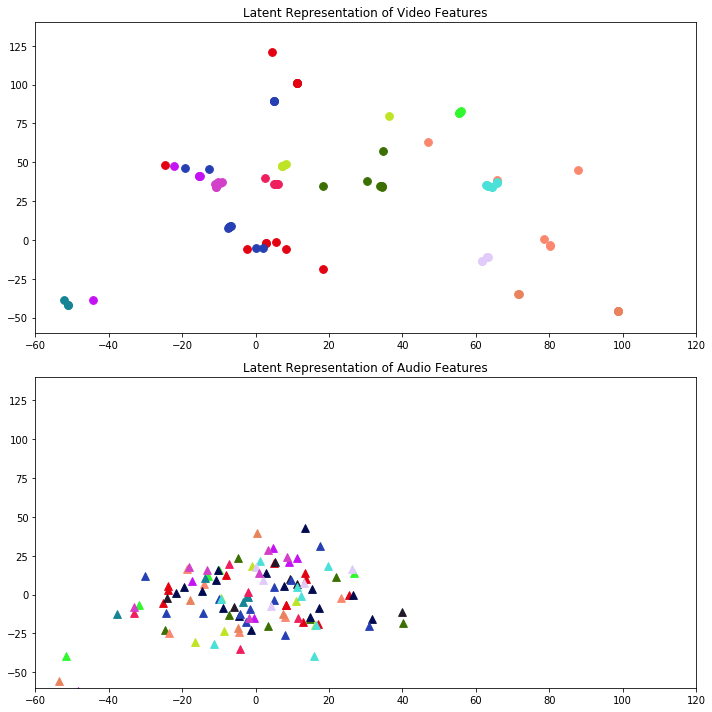

In [393]:
#get x,y coordinates and labels from loaded data, that correspond to celebrity indices
plot_x_v = list(map([x[0] for x in x_v].__getitem__, indices))
plot_y_v = list(map([x[1] for x in x_v].__getitem__, indices))
plot_x_a = list(map([x[0] for x in x_a].__getitem__, indices))
plot_y_a = list(map([x[1] for x in x_a].__getitem__, indices))
l = list(map(labels.__getitem__, indices))
classes = list(dict.fromkeys(l))

#plot TSNE visualiation
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#generate random colors of appropate size
random.seed(1234)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(celebrities))]

#video
for i, (x_,y_,l_) in enumerate(zip(plot_x_v,plot_y_v,l)):
    scatter = ax[0].scatter(x_,y_,c=colors[classes.index(l_)], label = l_, marker = 'o', s=60)
ax[0].set_title('Latent Representation of Video Features')
#audio
for i, (x_,y_,l_) in enumerate(zip(plot_x_a,plot_y_a,l)):
    ax[1].scatter(x_,y_,c=colors[classes.index(l_)], label = l_, marker = '^',s=60)
ax[1].set_title('Latent Representation of Audio Features')
ax[0].set_xlim([-60, 120])
ax[0].set_ylim([-60, 140])
ax[1].set_xlim([-60, 120])
ax[1].set_ylim([-60, 140])
fig.tight_layout()


### Visualize high dimensional manifolds in joint subspace learnt by VAE

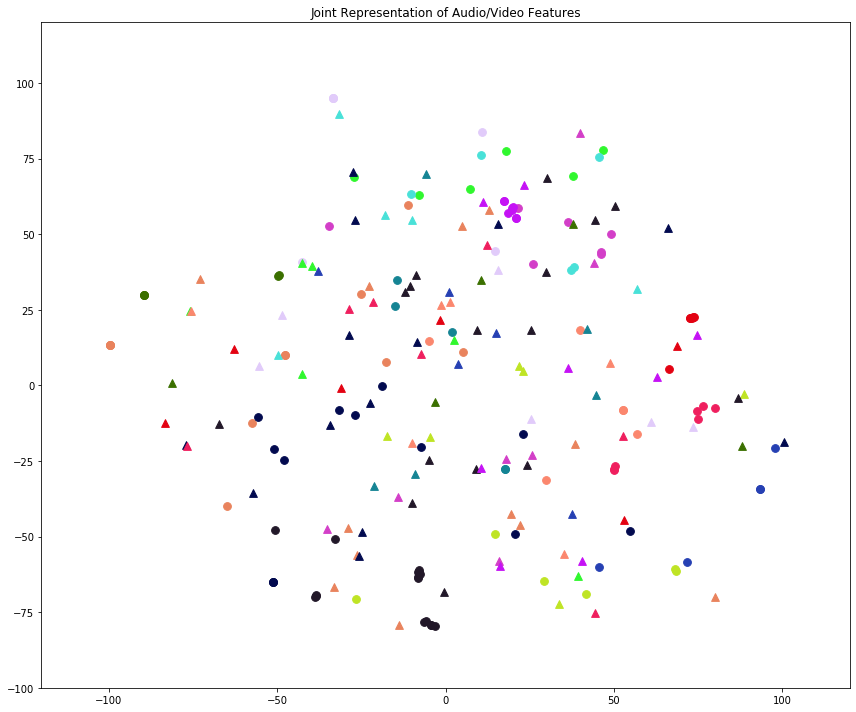

In [394]:
plot_x_v = list(map([x[0] for x in z_v].__getitem__, indices))
plot_y_v = list(map([x[1] for x in z_v].__getitem__, indices))
plot_x_a = list(map([x[0] for x in z_a].__getitem__, indices))
plot_y_a = list(map([x[1] for x in z_a].__getitem__, indices))
l = list(map(labels.__getitem__, indices))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,10))
#video
for i, (x_,y_,l_) in enumerate(zip(plot_x_v,plot_y_v,l)):
    ax.scatter(x_,y_,c=colors[classes.index(l_)-2], label = l_, marker = 'o', s=60)
#audio
for i, (x_,y_,l_) in enumerate(zip(plot_x_a,plot_y_a,l)):
    ax.scatter(x_,y_,c=colors[classes.index(l_)-2], label = l_, marker = '^',s=60)
ax.set_xlim([-120, 120])
ax.set_ylim([-100, 120])
ax.set_title('Joint Representation of Audio/Video Features')
fig.tight_layout()


### Cluster high dimensional manifolds using DBSCAN

In [383]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2)
clustering.fit(original_x_v)



DBSCAN(eps=3, min_samples=2)

In [385]:
len(set(clustering.labels_))

517

### Cross-modal retrieval using learnt VAE representations

In [5]:
from torch.utils.data import Dataset

"""Dataset Class for Audiovisual data from Voxceleb1"""
class IdentificationDataset(Dataset):
    
    def __init__(self, path, train, audio_transform=None, video_transform=None):
        #dataset split from data download site
        iden_split_path = os.path.join(path, 'iden_split.txt')
        split = pd.read_table(iden_split_path, sep=' ', header=None, names=['phase', 'path'])
        
        if train:
            phases = [1, 2]
        
        else:
            phases = [3]
            
        mask = split['phase'].isin(phases)
        self.dataset = split['path'][mask].reset_index(drop=True)
        self.path = path
        self.train = train
        self.audio_transform = audio_transform
        self.video_transform = video_transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        #path like id10003/L9_sh8msGV59/00001.wav
        track_path = self.dataset[idx]
        #path to audio data
        audio_path = os.path.join(self.path, 'audio', track_path)
        #path to video data
        video_path = os.path.join(self.path, 'video', '/'.join(track_path.split('/')[:-1])) + '/'
        #path to URL and timestamp metadata
        txt_path = video_path + track_path.split('/')[-1].replace('.wav','')+'.txt'

        if os.path.exists(audio_path) and os.path.exists(txt_path):
           
            # read .wav
            rate, samples = wavfile.read(audio_path)
            # extract label from path like id10003/L9_sh8msGV59/00001.txt
            # subtracting 1 because PyTorch assumes that C_i in [0, 1251-1]
            label = int(track_path.split('/')[0].replace('id1', '')) - 1

            ## parameters
            window = 'hamming'
            # window width and step size
            Tw = 25 # ms
            Ts = 10 # ms
            # frame duration (samples)
            Nw = int(rate * Tw * 1e-3)
            Ns = int(rate * (Tw - Ts) * 1e-3)
            # overlapped duration (samples)
            # 2 ** to the next pow of 2 of (Nw - 1)
            nfft = 2 ** (Nw - 1).bit_length()
            pre_emphasis = 0.97

            # preemphasis filter
            samples = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

            # removes DC component of the signal and add a small dither
            samples = signal.lfilter([1, -1], [1, -0.99], samples)
            dither = np.random.uniform(-1, 1, samples.shape)
            spow = np.std(samples)
            samples = samples + 1e-6 * spow * dither

            if self.train:
                # segment selection
                segment_len = 2 # sec
                upper_bound = len(samples) - segment_len * rate
                start = np.random.randint(0, upper_bound)
                end = start + segment_len * rate
                samples = samples[start:end]

            # spectogram spec = freq x time
            
            _, _, spec = signal.spectrogram(samples, rate, window, Nw, Ns, nfft, 
                                            mode='magnitude', return_onesided=True)

            # multiply by 1600
            spec *= rate / 10

            #apply normalization
            if self.audio_transform:
                spec = self.audio_transform(spec)
                
            #identify video frames corresponding to wav file    
            all_frames = dict(zip([x.lstrip("0") for x in os.listdir(video_path)],[x for x in os.listdir(video_path)]))
            #get corresponding frames from corresponding txt file
            f=open(txt_path,"r")
            lines=f.readlines()
            result=[]
            for x in lines:
                result.append(x.split(' ')[0])
            f.close()
            result = result[7:]
            #collect corresponding frames
            images_in_tensor = []
            for frame in result:
                if frame.lstrip("0") + '.jpg' in all_frames:
                    images_in_tensor.append(frame.lstrip("0") + '.jpg')
            imgs = io.imread_collection([video_path + all_frames[x] for x in images_in_tensor], conserve_memory = True)
            #convert to tensor and resize frames to 23 x 23
            if len(imgs) > 0:
                frames = torch.stack([self.video_transform(cv2.resize(img, (60,60))) for img in imgs])
            else:
                return

            return label, spec, frames
        else:
            return
       
    
class Normalize(object):
    """Normalizes voice spectrogram (mean-varience)"""
    
    def __call__(self, spec):
        
        # (Freq, Time)
        # mean-variance normalization for every spectrogram (not batch-wise)
        mu = spec.mean(axis=1).reshape(257, 1)
        sigma = spec.std(axis=1).reshape(257, 1)
        spec = (spec - mu) / sigma

        return spec

class ToTensor(object):
    """Convert spectogram to Tensor."""
    
    def __call__(self, spec):
        F, T = spec.shape
        
        # now specs are of size (Freq, Time) and 2D but has to be 3D (channel dim)
        spec = spec.reshape(1, F, T)
        
        # make the ndarray to be of a proper type (was float64)
        spec = spec.astype(np.float32)
        
        return torch.from_numpy(spec)
        
DATASET_PATH = '/usr/xtmp/hs285/'
EPOCH_NUM = 30

torch.backends.cudnn.deterministic = True
#batch size
B = 100
#hyperparameters (need to tune)
WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
DEVICE = 'cuda:0'
NUM_WORKERS = 1


audio_transforms = Compose([
    Normalize(),
    ToTensor()
])
import torchvision.transforms
video_transform = torchvision.transforms.ToTensor()

#custom collate function for dataloader because data is variable size
def collate_fn(batch):
    batch = list(filter(lambda x : x is not None, batch))
    label = []
    audio = []
    video = []
    for item in batch:
        label.append(item[0])
        audio.append(item[1])
        video.append(item[2])
    return {'label': label,
           'audio': audio,
           'video_frames': video}

#create pytorch dataloader objects
trainset = IdentificationDataset(DATASET_PATH, train=True, audio_transform=audio_transforms, video_transform=video_transform)
trainsetloader = torch.utils.data.DataLoader(trainset, batch_size=B, num_workers=NUM_WORKERS, collate_fn=collate_fn,shuffle=True)

testset = IdentificationDataset(DATASET_PATH, train=False, audio_transform=audio_transforms, video_transform=video_transform)
testsetloader = torch.utils.data.DataLoader(testset, batch_size=1, collate_fn=collate_fn,num_workers=NUM_WORKERS*2)

In [ ]:
#find celebrity name from id in dataset
def find_celebrity_from_id(s):
    return list(name2id.keys())[list(name2id.values()).index(s)]

#compute distance between latent representations
def euclidean_dis(x, reconstructed_x):
	dis = torch.dist(x,reconstructed_x,2)
	return dis


#compute loss when given an image and when identifying the most related audio clip
def calculate_score_va(video_feature, audio_feature):
    vae_audio.eval()
    vae_video.eval()
    video_feature = video_feature.float()
    audio_feature = audio_feature.float()
    loss_MSE = nn.MSELoss()
    with torch.no_grad():
        reconstructed_audio, mu1, logvar1 = vae_video(video_feature)
        reconstructed_video, mu2, logvar2 = vae_audio(audio_feature)
        loss1 = euclidean_dis(mu1,mu2)
        loss2 = loss_MSE(reconstructed_audio, reconstructed_video)
    return loss1.item()*0.5 + loss2.item()*0.5


#compute loss when given an audio clip and identify most related image
def calculate_score_av(audio_feature, video_feature):
    vae_audio.eval()
    vae_video.eval()
    video_feature = video_feature.float()
    audio_feature = audio_feature.float()
    loss_MSE = nn.MSELoss()
    with torch.no_grad():
        reconstructed_audio, mu1, logvar1 = vae_video(video_feature)
        reconstructed_video, mu2, logvar2 = vae_audio(audio_feature)
        loss1 = euclidean_dis(mu1,mu2)
        loss2 = loss_MSE(reconstructed_audio, reconstructed_video)
    return loss1.item()*0.5 + loss2.item()*0.5

In [ ]:
#choose which sample to retrieve from (here the sample corresponds to a clip of aamir khan)
chosen_sample = 0
stop = False

latent_dim = 100

audio_encode = audio_encoder(latent_dim)
audio_decode = general_decoder(latent_dim)
video_encode = visual_encoder(latent_dim)
video_decode = general_decoder(latent_dim)
vae_audio = VAE(latent_dim, audio_encode, audio_decode)
vae_video = VAE(latent_dim, video_encode, video_decode)
# vae_audio.cuda()
# vae_video.cuda()

#load trained vae model
vae_audio.load_state_dict(torch.load('8_msvae_a.pkl', map_location = torch.device('cpu')))
vae_video.load_state_dict(torch.load('8_msvae_v.pkl', map_location = torch.device('cpu')))

#iterate through test set for cross-modal retrieval (video -> audio and audio -> video)
for idx, sample in enumerate(testsetloader):
    if idx == chosen_sample and not stop:
        v = sample['video_frames']
        a = sample['audio']
        
        #convert video tensor to [4,529]
        v = torch.flatten(torch.mean(v[0], dim = 1), start_dim = 1, end_dim = 2)
        #convert audio tensor to [1,257]
        a = torch.mean(a[0],dim = 2)
        label = sample['label']
        #keep track of scores
        score_v = []
        score_a = []
        for i, target in enumerate(testsetloader):
            if i != random_idx:
                print('inner idx {}'.format(i), end = '\r')
                v_target = target['video_frames']
                a_target = target['audio']
                if len(v_target)>0 and len(a_target)>0:
                    v_target = torch.flatten(torch.mean(v_target[0], dim = 1), start_dim = 1, end_dim = 2)
                    #get single from if target is visual modality ([1,529])
                    v_target = torch.unsqueeze(v_target[0],0)
                    a_target = torch.mean(a_target[0],dim = 2)
                    #compute scores
                    score_v.append(calculate_score_av(a, v_target))
                    score_a.append(calculate_score_va(v, a_target))
        #identify indices that correspond to lowest loss score
        score_index_a = np.argsort(score_a)
        score_index_v = np.argsort(score_v)
        stop = True
    if stop:
        break

In [ ]:
#keep track of indices to ignore in test set because they are nonetype
ignore = []
for i,j in enumerate(testset):
    print(i, end = '\r')
    if j is None:
        ignore.append(i)

In [208]:
#the celebrity that we are conducting cross-modal retrieval on (for demonstration purposes)
find_celebrity_from_id(testset.dataset[0].split('/')[0])

'Aamir_Khan'

In [211]:
#identities whose voice corresponded to the lowest latent loss given the video frames of aamir khaan's face
for i in range(5):
    most_similar_audio = testset.dataset[score_index_a[i]+1].split('/')[0]
    print(find_celebrity_from_id(most_similar_audio))
#identities whose face corresponded to the lowest latent loss given the audio clip of aamir khan's voice
print('5 celebrities most likely to look their voice sounds like Aamir Khan')
for i in range(5):
    most_similar_video = testset.dataset[score_index_v[i]+1].split('/')[0]
    print(find_celebrity_from_id(most_similar_video))
    


Robbie_Kay
Constance_Zimmer
Chris_Lowell
Scott_Porter
Seth_Rogen
5 celebrities most likely to look their voice sounds like Aamir Khan
Angela_Kinsey
Angela_Kinsey
Teri_Hatcher
Angela_Kinsey
Toby_Stephens


In [ ]:
#find the relative score of the correct cross-modal retrievals of an aamir khan video frame/audio clip 
i = 0
found_audio, found_video = False, False
#track mean recipricol rank
rr_av, rr_va = 0,0
for sample in (testsetloader):
    v_target = target['video_frames']
    a_target = target['audio']
    if len(v_target)>0 and len(a_target)>0:
        print(score_index_a[i]+1, end = '\r')
        if score_index_a[i]+1 not in ignore and label[0] == testset[score_index_a[i]+1][0]:
            print('found audio match at {}'.format(i))
            found_audio = True
            rr_va += 1/(i + 1)
        if score_index_v[i]+1 not in ignore and label[0] == testset[score_index_v[i]+1][0]:
            print('found video match at {}'.format(i))
            found_video = True
            rr_av += 1/(i + 1)
        if found_audio and found_video:
            break
        i += 1
print(rr_av/len(testset), rr_va/len(testset))

### Display Example Sample Data

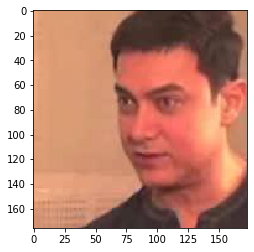

In [32]:
from PIL import Image

example_image1 = Image.open('/usr/xtmp/hs285/video/'+'/'.join(testset.dataset[0].split('/')[:-1]) + '/0001950.jpg', 'r')
example_image2 = Image.open('/usr/xtmp/hs285/video/'+'/'.join(testset.dataset[0].split('/')[:-1]) + '/0001925.jpg', 'r')
plt.imshow(example_image1)

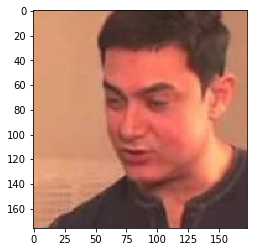

In [31]:
plt.imshow(example_image2)

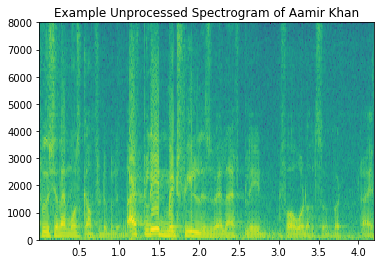

In [40]:
example_wav = '/usr/xtmp/hs285/audio/'+ testset.dataset[0]
samplingFrequency, signalData = wavfile.read(example_wav)
plt.specgram(signalData,Fs=samplingFrequency)
plt.title('Example Unprocessed Spectrogram of Aamir Khan')
plt.show()